<a href="https://colab.research.google.com/github/AntonioDeFA/etl_pyspark/blob/develop/Dados_IBGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark findspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=8fb0181b0915c58e62ce0b7b6961af8969721572af506a48aedbd99d903eca1e
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [106]:
import findspark
import unicodedata

import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql import SparkSession, Row
from pyspark.sql.window import Window


findspark.init()

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode('ASCII')

udf_remove_accents = udf(remove_accents,
                         StringType())

spark = SparkSession.builder \
    .appName("Dados IBGE") \
    .getOrCreate()

spark.udf.register("sql_remove_accents",
                   remove_accents,
                   StringType())

input_path_ibge = "/content/cities-brazil-ibge.csv"
data_ibge = spark.read.csv(input_path_ibge,
                           header=True,
                           inferSchema=True,
                           sep=",",
                           encoding="UTF-8")

input_path_covid = "/content/cases-brazil-cities-time_2022.csv"
data_covid = spark.read.csv(input_path_covid,
                            header=True,
                            inferSchema=True,
                            sep=",",
                            encoding="UTF-8")

data_ibge.createOrReplaceTempView("tb_ibge")
data_covid.createOrReplaceTempView("tb_covid")

spark.sql("SELECT epi_week, date, state, \
          upper(sql_remove_accents(city)) AS city, \
          ibgeID, newDeaths, deaths, newCases, \
          totalCases, deaths_per_100k_inhabitants, \
          totalCases_per_100k_inhabitants, \
          deaths_by_totalCases FROM tb_covid")\
          .createOrReplaceTempView("tb_covid_sem_acento")

spark.sql("SELECT epi_week, date, state, \
          SUBSTR(city, 1, INSTR(city, '/') - 1) AS city, \
          ibgeID, newDeaths, deaths, newCases, \
          totalCases, deaths_per_100k_inhabitants, \
          totalCases_per_100k_inhabitants, \
          deaths_by_totalCases FROM tb_covid_sem_acento")\
          .createOrReplaceTempView("tb_covid_sem_estado")


# spark.sql("Select * from tb_covid_sem_estado where city='JOAO PESSOA'").show()

tb_ibge_covid_merged = spark.sql("SELECT * FROM tb_covid_sem_estado \
                                JOIN tb_ibge ON LocalCidade = city")

tb_ibge_covid_merged.createOrReplaceTempView("tb_data_atualizada")

# spark.sql("SELECT * FROM tb_data_atualizada WHERE city = 'JOAO PESSOA'").show()

window_spec = Window.partitionBy("city").orderBy(desc("date"))

df_ordenado_data_recente = tb_ibge_covid_merged.withColumn("row",
                                                           row_number().
                                                           over(window_spec))
df_filtrado_data_recentes = df_ordenado_data_recente.filter(col("row") == 1)\
                                                            .drop("row")

df_filtrado_data_recentes.show()



+--------+----------+-----+--------------------+-------+---------+------+--------+----------+---------------------------+-------------------------------+--------------------+--------+--------------------+-------+-------------------+------------+---------+---------+------------------+----------------+-------------+-----+-----------------------+-----------------------+--------+
|epi_week|      date|state|                city| ibgeID|newDeaths|deaths|newCases|totalCases|deaths_per_100k_inhabitants|totalCases_per_100k_inhabitants|deaths_by_totalCases|IBGECode|         LocalCidade|LocalUF|        LocalEstado|RegiaoBrasil| Latitude|Longitude|         Gentilico|PopEstimada_2018|PopCenso 2010| IDHM|ReceitasRealizadas_2014|DespesasEmpenhadas_2014|Pib_2014|
+--------+----------+-----+--------------------+-------+---------+------+--------+----------+---------------------------+-------------------------------+--------------------+--------+--------------------+-------+-------------------+----------

In [108]:
df_filtrado_PB = df_filtrado_data_recentes.filter(col("state") == "PB")
pd_filtrado_PB = df_filtrado_PB.orderBy(desc('deaths')).toPandas()



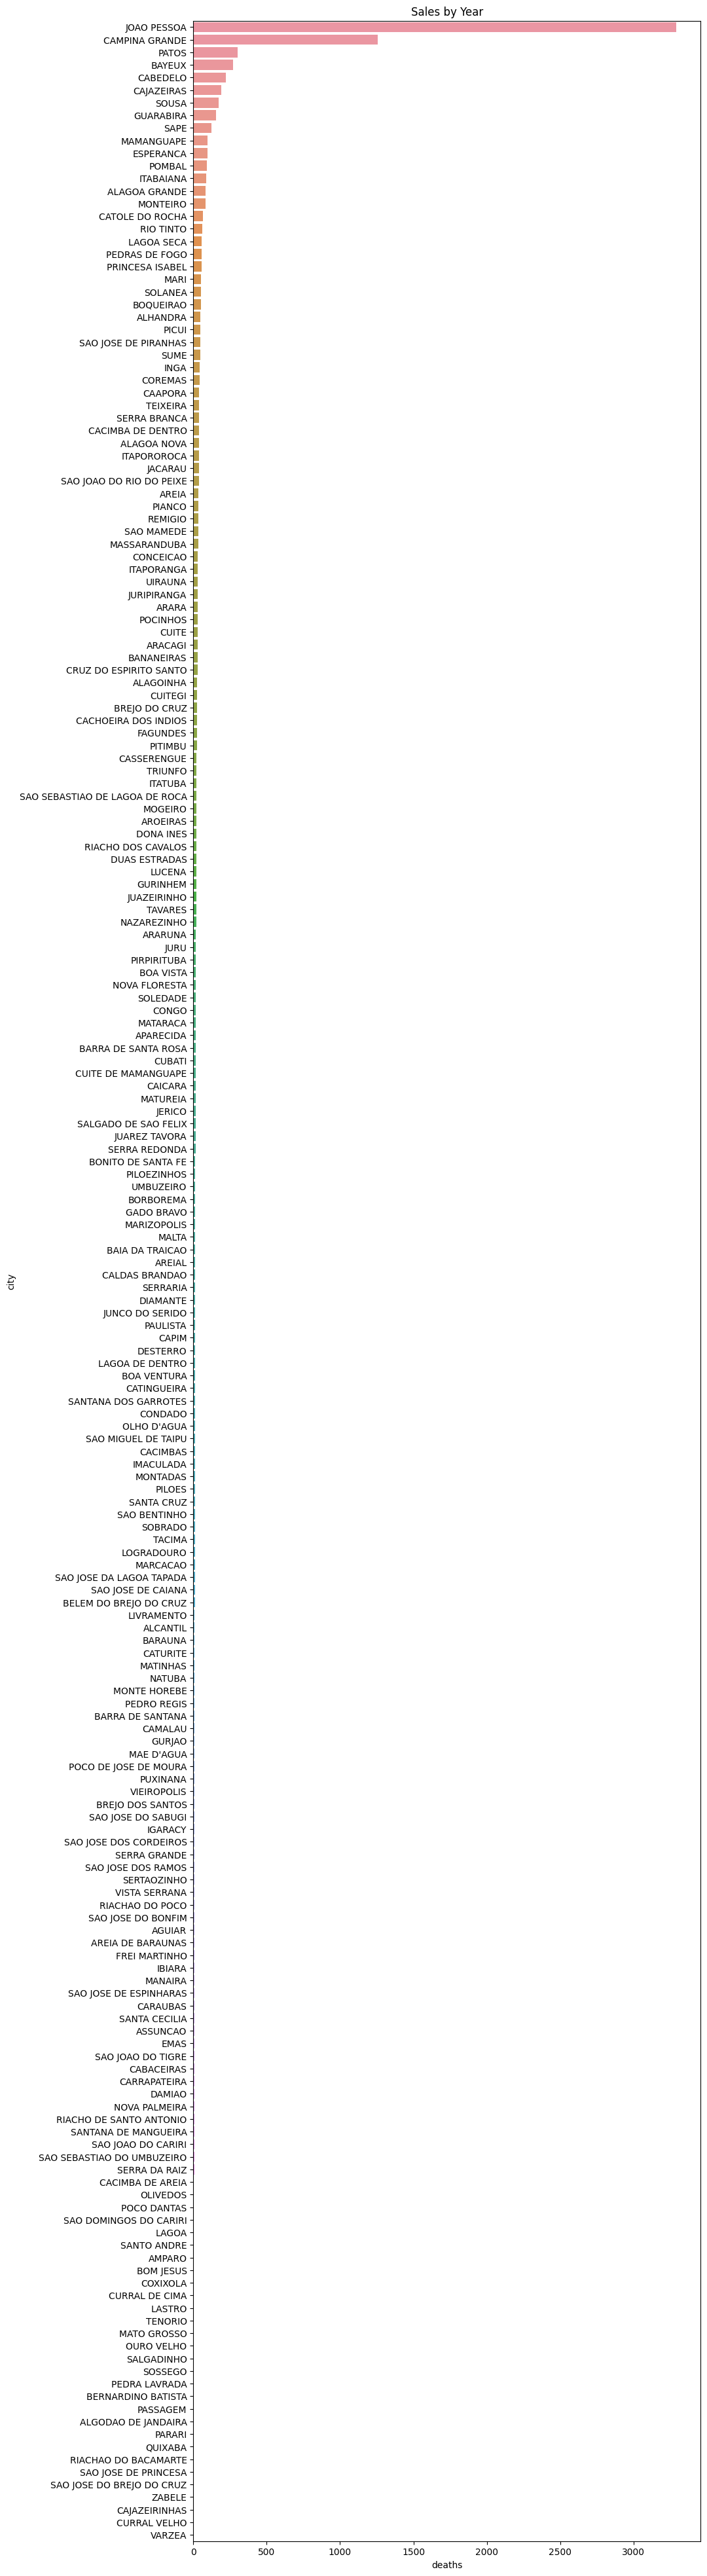

In [109]:
plt.figure(figsize=(10, 50))
sns.barplot(x="deaths", y="city", data=pd_filtrado_PB)
plt.title('Sales by Year')
# .createOrReplaceTempView("tb_data_atualizada")

# spark.sql("SELECT * FROM tb_data_atualizada WHERE city = 'JOAO PESSOA'").show()

# df = tb_ibge_covid_merged.orderBy(col('date').desc())
# registro_recente = df.limit(1)



# output_path = "caminho/para/saida.csv"
# data_transformed.write.csv(output_path, header=True)

# # Encerrar a sessão Spark
spark.stop()
